Trabalho Prático 2 - Trabalho Prático 2:  Localização de Objetos


Grupo: Esthefanie Pessoa Lanza (2015112736) e João Antonio Dornelas (2014103407)


Importamos todas as bibliotecas necessárias e, através de um path, abrimos as imagens de query e target.

In [1]:
#Bibliotecas utilizadas
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt

print "Versão utilizada: %s" % (cv2.__version__)

# Caminho das imagens
# Starbucks
imagePathQuery = 'exemplos/002_starbucks_query.png';
imagePathTarget = 'exemplos/002_starbucks_target.png';

# Coke
# imagePathQuery = 'exemplos/003_coke_query.png';
# imagePathTarget = 'exemplos/003_coke_target2.png';

# Apple
# imagePathQuery = 'tp2/exemplos/001_apple_query.png';
# imagePathTarget = 'tp2/exemplos/001_apple_target.png';

img = cv2.imread(imagePathQuery);
imgTarget = cv2.imread(imagePathTarget);

Versão utilizada: 3.3.0


Criamos as funções de exibição das imagens, e testamos com as imagens de query e target.

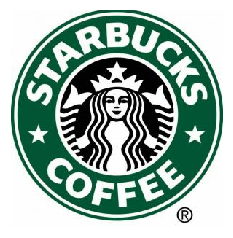

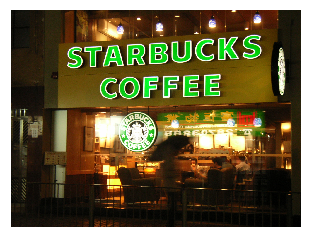

In [2]:
def printImageColor( img ):
    rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgbImg, cmap = 'gray')
    plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.show()   
    return

def printImage( img ):
    plt.imshow(img, cmap = 'gray')
    plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.show()   
    return

printImageColor(img)
printImageColor(imgTarget)

Convertemos as imagens para tons de cinza e aplicamos filtros para retirada de ruídos do tipo sal e pimenta.

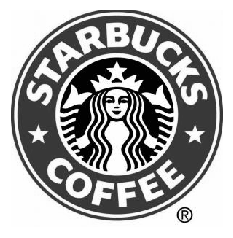

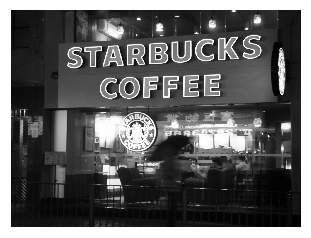

In [3]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
grayTarget = cv2.cvtColor(imgTarget,cv2.COLOR_BGR2GRAY)

# Filtro utilzado para remover ruído do tipo sal e pimenta
grayTarget=cv2.medianBlur(grayTarget,3)

printImage(gray)
printImage(grayTarget)

Analisamos as dimensões da imagem de target, e caso a mesma seja muito pequena, redimensionamos para um tamanho maior. Dessa forma, conseguimos encontrar keypoints mais consistentes na aplicação do algoritmo de extração de features. 

In [4]:
alturaTarget, larguraTarget = imgTarget.shape[:2]

if alturaTarget < 300:
    print "Aumentando o tamanho da imagem"
    grayTarget= cv2.resize(grayTarget, (2*larguraTarget,2*alturaTarget), interpolation = cv2.INTER_NEAREST)
    imgTarget= cv2.resize(imgTarget, (2*larguraTarget,2*alturaTarget), interpolation = cv2.INTER_NEAREST)
    printImage(grayTarget)

Para melhorar a acurácia das features que queremos encontrar, precisamos manter somente o objeto principal da cena. Encontramos primeiramente a silhueta do objeto principal, e então recortamos a imagem para manter somente esse objeto. Dessa forma, reduzimos o número de interferências na imagem (Como objetos do fundo) e encontraremos somente features que pertencem ao objeto principal.

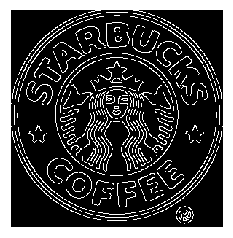

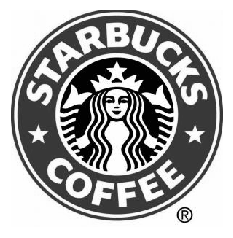

In [5]:
# Encontramos contornos
blur = cv2.GaussianBlur(gray,(3,3),0)
blur = cv2.GaussianBlur(blur,(7,7),0)
edged = cv2.Canny(blur, 30, 200)

printImage(edged)

#Encontra pontos que nao sejam zero
points = cv2.findNonZero(edged)
#Encontra a região que abrange os pontos
hull = cv2.convexHull(points)
# Cortamos a imagem
x,y,w,h = cv2.boundingRect(hull)
cropImage = gray

printImage( cropImage )

Com a imagem já tratada, é necessário encontrar os descritores nas imagens de query e target. Para isso, foram usados diversos descritores que estão comentados no bloco abaixo. Foram obtidos melhores resultados usando o descritor SIFT. Entretanto, como este não é nativo do openCV, foi escolhido o descritor ORB para a versão final. Este descritor, mesmo alterando seus parâmetros diversas vezes, não apresentou bons resultados ao lidar com o logo da apple e a lata de coca menor (O que apresenta ser um forte indício da baixa acurácia do descritor em imagens de baixa resolução, ou com grande quantidade de ruído).

- Keypoints Query -


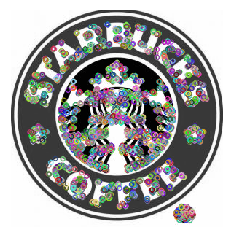

- Keypoints Target -


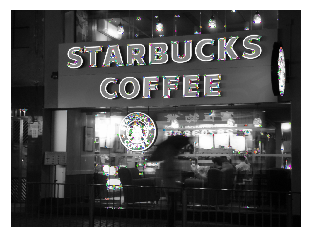

In [6]:
# SIFT DEFAULT
# kp1, des1 = sift.detectAndCompute(cropImage, None)
# kp2, des2 = sift2.detectAndCompute(grayTarget,None)

# SIFT 
# sift = cv2.xfeatures2d.SIFT_create(1000000, 15, 0.10, 40, 1.3)
# sift2 = cv2.xfeatures2d.SIFT_create(1000000, 15, 0.03, 40, 1.9)

# SURF
# hessian_threshold = 30
# surf = cv2.xfeatures2d.SURF_create(hessian_threshold)
# kp1, des1 = surf.detectAndCompute(imageResult, None)
# kp2, des2 = surf.detectAndCompute(grayTarget, None)

# FAST
# fast = cv2.FastFeatureDetector_create()
# kp1 = fast.detect(img,None)
# kp2 = fast.detect(imgTarget, None)

# ORB DEFAULT
# orb=cv2.ORB_create(10000)
# kp1, des1 = orb.detectAndCompute(cropImage, None)
# kp2, des2 = orb.detectAndCompute(grayTarget,None)

# ORB 
orb=cv2.ORB_create(4000, 1.1, 10, 8, 0, 2, 0, 31, 45)

def calculaKeyPointsQuery(orb, gray):
    kp1, des1 = orb.detectAndCompute(gray, None)
    return kp1, des1

def calculaKeyPointsTarget(orb, grayTarget):
    kp2, des2 = orb.detectAndCompute(grayTarget,None)
    return kp2, des2

kp1, des1 = calculaKeyPointsQuery(orb, gray)
kp2, des2 = calculaKeyPointsTarget(orb, grayTarget)

print "- Keypoints Query -"
printImage(cv2.drawKeypoints(gray, kp1, None, flags=0))

print "- Keypoints Target -"
printImage(cv2.drawKeypoints(grayTarget, kp2, None, flags=0))



Após encontrar os keypoints, realizamos o match entre as duas imagens, buscando encontrar o objeto de uma cena em outra, e imprimimos na tela todos os pontos de semelhança encontrados.

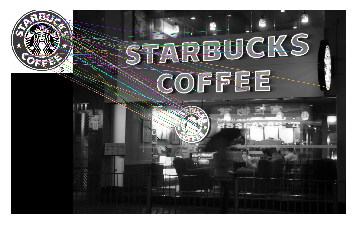

Número de matches encontrados: 1523


In [7]:
# Criamos o BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

def encontraMatches(bf, kp1,des1,kp2,des2, gray, grayTarget): 
    # Damos os matches nos descritores
    matches = bf.match(des1,des2)

    # Ordenamos o 
    matches = sorted(matches, key = lambda x:x.distance)


    return matches

matches = encontraMatches(bf, kp1,des1,kp2,des2, gray, grayTarget)
printImage(cv2.drawMatches(gray,kp1,grayTarget,kp2,matches[:60], None, flags=2))
print "Número de matches encontrados: %d" % len(matches)

Caso o número de matchs encontrados entre as imagens seja superior à um limiar pré-estabelecido (5), encontramos a homografia correspondente na imagem de destino (Bounding box que contém o objeto). Imprimimos então o número de objetos encontrados, e a composição da cena original com o retângulo do objeto. 

In [8]:
MIN_MATCH = 5
objects = []

if (len(matches)>MIN_MATCH):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches[:40] ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches[:40] ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    
    h,w = cropImage.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    result = cv2.polylines(imgTarget,[np.int32(dst)],True,(0,0,255),5, cv2.LINE_AA)
    objects.append(np.int32(dst))
    
print "Objetos encontrados: %d" % (len(objects))

Objetos encontrados: 1


Utilizando os pontos da homografia encontrada, calculamos e imprimimos na tela as coordenadas do centróide do objeto e a composição da cena original com o retângulo do objeto. 

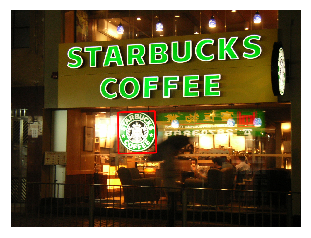

>> o1: 555 543


In [9]:
printImageColor(imgTarget)

for i in range(0, len(objects)):
    arrayVertices = objects[i]
    vA = arrayVertices[0][0]
    vB = arrayVertices[1][0]
    vC = arrayVertices[2][0]
    vD = arrayVertices[3][0]

    centerX = (vA[0] + vB[0] + vC[0] + vD[0])/4
    centerY = (vA[1] + vB[1] + vC[1] + vD[1])/ 4
    
    print ">> o%d: %d %d" % ((i + 1), centerX, centerY)

